## Detección de raza de perros

http://vision.stanford.edu/aditya86/ImageNetDogs/

## Ejemplo  de uso

Vamos a ver como podemos utilizar el modelo `Faster R-CNN` disponible en `torchvision` para generar detecciones. En primer lugar vamos a utilizar el mismo dataset que hemos usado en los vídeos anteriores, el dataset `VOC` (el modelo `Faster R-CNN` de `torchvision` está entrenado en el dataset `COCO`)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

path = "/content/data"
os.mkdir(path)

In [4]:
import shutil
shutil.copy("/content/drive/MyDrive/datasets/stanford_dogs/annotation.tar", "/content/data/anotation.tar")
shutil.copy("/content/drive/MyDrive/datasets/stanford_dogs/images.tar", "/content/data/images.tar")

shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/images.tar", "/content/data")
shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/annotation.tar", "/content/data")

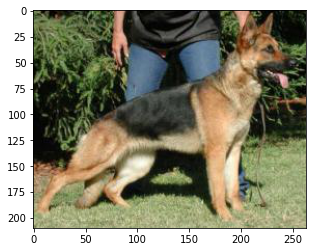

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('/content/data/Images/n02106662-German_shepherd/n02106662_11808.jpg')

imgplot = plt.imshow(img)

In [ ]:
import torch
import torchvision 
from torchvision import datasets, transforms, models
from torch import optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib
import matplotlib.patches as patches
import glob
import xml.etree.ElementTree as ET
import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
dataset = datasets.ImageFolder("/content/data/Images/")

In [ ]:
label = list(sorted(os.listdir("/content/data/Images/")))

In [ ]:
list_annotations = []
list_images = []

In [ ]:
for l in label:
    labels_annotation = list(sorted(os.listdir(os.path.join("/content/data/Annotation", l))))
    images = list(sorted(os.listdir(os.path.join("/content/data/Images", l))))
    list_annotations += labels_annotation
    list_images += images

In [ ]:
class Dogs(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.img_path = "/content/data/Images/"
        self.annotation_path = "/content/data/Annotation/"
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, idx):
        image, type_  = self.dataset[idx]
 
        image = cv2.imread(self.img_path + label[type_] + "/" + list_images[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
        image /= 255.
        
        image_id = torch.tensor([idx])
#         label_image = torch.as_tensor(type_, dtype=torch.int64).view(-1,)
        label_image = torch.ones(1, dtype=torch.int64)
        
        tree = ET.parse(self.annotation_path + label[type_] + "/" + list_annotations[idx])
        root = tree.getroot()
        boxes = []
        value = []
        for x in root[5][4][:]:
            value.append(int(x.text))
        boxes.append(value)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
            
        area = (boxes[0][3]-boxes[0][1])*(boxes[0][2]-boxes[0][0])
        area = torch.as_tensor(area, dtype=torch.float32).view(-1, )
        
        iscrowd = torch.zeros((1, ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = label_image
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transform is not None:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': label_image
            }
            sample = self.transform(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = target['boxes'].float()
        
        return image, target
        
    def __len__(self):
        return len(self.dataset)

In [ ]:
# # Albumentations
# def get_train_transform():
#     return A.Compose([
#         A.Flip(0.5),
#         A.Resize(256, 256),
#         ToTensorV2(p=1.0)
#     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# def get_valid_transform():
#     return A.Compose([
#         ToTensorV2(p=1.0)
#     ], bbox_params={'format': 't', 'label_fields': ['labels']})

In [ ]:
dog_dataset = Dogs(dataset, transform=None)

In [ ]:
rs = dog_dataset.__getitem__(1000)

In [ ]:
# fig, ax = plt.subplots()
# ax.imshow(rs[0].numpy().transpose(1, 2,0))
# rect = patches.Rectangle((rs[1]["boxes"][0][0], rs[1]["boxes"][0][1]), (rs[1]["boxes"][0][2]-rs[1]["boxes"][0][0]), (rs[1]["boxes"][0][3]-rs[1]["boxes"][0][1]), linewidth=2, edgecolor="r", facecolor='none')
# ax.add_patch(rect)
# ax.text(rs[1]["boxes"][0][0], rs[1]["boxes"][0][1]-5, label[rs[1]["labels"]], color="r", fontsize=10)

In [ ]:
voc_classes = 120

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = dog_dataset[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([voc_classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, classes=voc_classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

KeyError: ignored

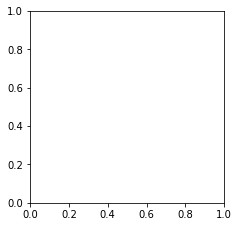

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dog_dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
batch_size = 32
#valid_size = 0.1

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio("/content/data/Images/", output="output", seed=666, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 20580 files [00:03, 6054.29 files/s]


In [ ]:
train_dataset = datasets.ImageFolder('/content/output/train/',transform=transform)
test_dataset = datasets.ImageFolder('/content/output/test/',transform=transform)
valid_dataset = datasets.ImageFolder('/content/output/val/',transform=transform)

In [ ]:
train_dataset
test_dataset
valid_dataset

Dataset ImageFolder
    Number of datapoints: 2009
    Root location: /content/output/val/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
train_dataset.class_to_idx

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [ ]:
from glob import glob

num_classes = len(glob("/content/data/Images/*"))

num_classes

120

In [ ]:
classes = glob("/content/output/train/*")
classes.sort()

{k:i.split("-")[-1] for k, i in enumerate(classes)}

{0: 'Chihuahua',
 1: 'Japanese_spaniel',
 2: 'Maltese_dog',
 3: 'Pekinese',
 4: 'Tzu',
 5: 'Blenheim_spaniel',
 6: 'papillon',
 7: 'toy_terrier',
 8: 'Rhodesian_ridgeback',
 9: 'Afghan_hound',
 10: 'basset',
 11: 'beagle',
 12: 'bloodhound',
 13: 'bluetick',
 14: 'tan_coonhound',
 15: 'Walker_hound',
 16: 'English_foxhound',
 17: 'redbone',
 18: 'borzoi',
 19: 'Irish_wolfhound',
 20: 'Italian_greyhound',
 21: 'whippet',
 22: 'Ibizan_hound',
 23: 'Norwegian_elkhound',
 24: 'otterhound',
 25: 'Saluki',
 26: 'Scottish_deerhound',
 27: 'Weimaraner',
 28: 'Staffordshire_bullterrier',
 29: 'American_Staffordshire_terrier',
 30: 'Bedlington_terrier',
 31: 'Border_terrier',
 32: 'Kerry_blue_terrier',
 33: 'Irish_terrier',
 34: 'Norfolk_terrier',
 35: 'Norwich_terrier',
 36: 'Yorkshire_terrier',
 37: 'haired_fox_terrier',
 38: 'Lakeland_terrier',
 39: 'Sealyham_terrier',
 40: 'Airedale',
 41: 'cairn',
 42: 'Australian_terrier',
 43: 'Dandie_Dinmont',
 44: 'Boston_bull',
 45: 'miniature_schnauze

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=8)
classes = list(range(num_classes))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(test_loader)*batch_size + len(valid_loader)*batch_size + len(train_loader)*batch_size

20640

In [ ]:
for batch in valid_loader:
    print(batch[0].size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size

In [ ]:
print(train_dataset[1000])

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 6)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train_dataset[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, classes=classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

In [ ]:
print(get_sample(10))

TypeError: ignored

TypeError: ignored

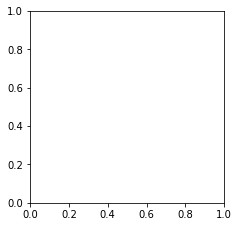

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train_dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Ahora podemos descargar el modelo entrenado

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Siguiendo la documentación, podemos usar este modelo en inferencia pasándole una lista de imágenes normalizadas entre 0-1 con las dimensiones `[C, H, W]` (pueden ser imágenes de diferente tamaño, el modelo ya se encarga del *resize*).

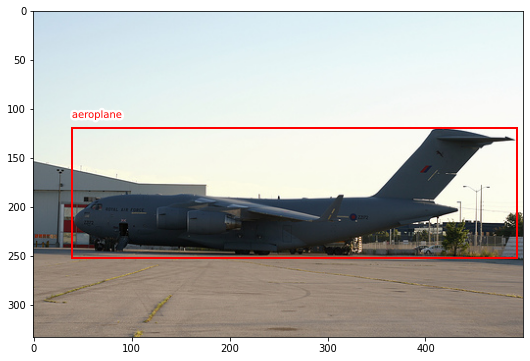

In [ ]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

In [ ]:
model.eval()
outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
outputs

[{'boxes': tensor([[ 38.9766, 123.2571, 463.2631, 244.7916],
          [394.6673, 239.3306, 417.8829, 248.7579],
          [ 83.8890, 211.9992,  97.7212, 245.2696],
          [391.7524, 240.2934, 407.5306, 248.3502],
          [297.7431, 236.6284, 325.2031, 250.0018],
          [ 33.2589, 174.6997, 368.3978, 247.6585],
          [297.8233, 236.4347, 324.7085, 249.9443],
          [ 88.0805, 211.7508,  96.9347, 233.4872],
          [209.9664, 119.5987, 489.9712, 232.0793],
          [276.2681, 239.4820, 298.6529, 247.7382],
          [  1.0193, 227.8070,  24.9193, 240.9534],
          [ 76.8103, 229.2830,  82.8956, 246.1568],
          [  9.1523, 234.0433,  16.6872, 241.9108],
          [268.0753, 238.7643, 301.0202, 249.1797],
          [392.7399, 238.6301, 419.9506, 249.2913]], grad_fn=<StackBackward>),
  'labels': tensor([ 5,  3,  1,  3,  3,  5,  8,  1,  5,  3, 15,  1, 11,  8,  8]),
  'scores': tensor([0.9950, 0.9116, 0.8834, 0.5434, 0.3926, 0.3855, 0.3645, 0.2069, 0.1535,
          

A la salida recibimos una lista con las detecciones de cada imagen (en nuestro caso solo una). Cada elemento de la lista es un `dict` con las cajas, etiquetas y las probabilidades asignadas a cada objeto detectado (que podemos filtrar para quedarnos, por ejemplo, con aquellas detecciones con probabilidad superior a un cierto valor). Es importante recordar que estas etiquetas corresponden al dataset `COCO`.

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Además, las cajas están en formato `[x_min, y_min, x_max, y_max]` mientras que nosotros estamos trabajando con `[x_min, y_min, width, height]`, por lo que tenemos que transformar las cajas.

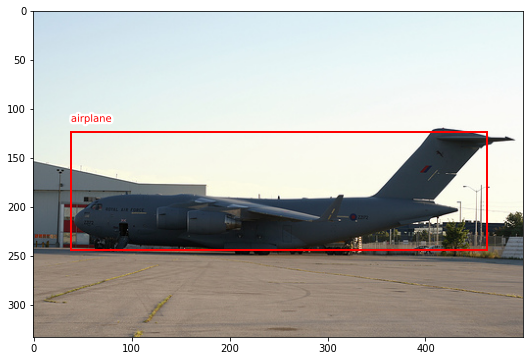

In [ ]:
img_np, anns = get_sample(4445)
# nos quedamos con la primera detección
bb = outputs[0]['boxes'][0].long().tolist()
bb = [bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]
plot_anns(img_np, (outputs[0]['labels'][:1], [bb]), classes=COCO_INSTANCE_CATEGORY_NAMES)
plt.show()

Puedes jugar con las siguientes celdas para ver detecciones sobre imágenes aleatorias del dataset. Debido a que el dataset `COCO` tiene mucha clases que el dataset `VOC` (90 vs 20), muchos objetos detectados correctamente pueden no aparecer en las anotaciones originales.

In [ ]:
def predict(img, threshold=0.8):
    model.eval()
    outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
    # nos quedamos con la primera detección
    bb = outputs[0]['boxes'][0].long().tolist()
    bbs = [[bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]] for o in outputs for bb, score in zip(o['boxes'], o['scores']) if score > threshold]
    labels = [lab for o in outputs for lab, score in zip(o['labels'], o['scores']) if score > threshold]
    return labels, bbs

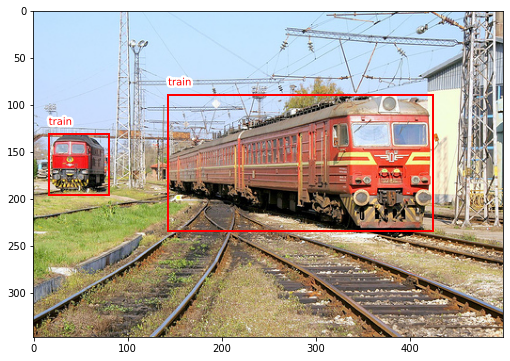

In [ ]:
ix = random.randint(0, len(train)-1)
img_np, anns = get_sample(ix)
plot_anns(img_np, anns)
plt.show()

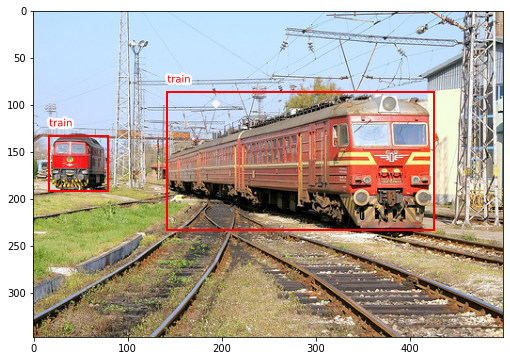

In [ ]:
anns = predict(img_np)
plot_anns(img_np, anns, classes=COCO_INSTANCE_CATEGORY_NAMES)
plt.show()

Si bien puedes utilizar este modelo ya entrenado para generar predicciones, si tu tarea incluye otros objetos no presentes en el dataset original tendrás que hacer `fine-tuning`, reentrenando la red con tu dataset. Puedes encontrar en la [documentación](https://pytorch.org/docs/stable/torchvision/models.html) instrucciones para entrenar de nuevo el modelo.

## Resumen

En este post hemos introducido la tarea de `detección de objetos` con `redes neuronales`. Esta tarea consiste en localizar y clasificar el máximo número de objetos presentes en una imagen. Hemos visto que existen dos grandes familias de arquitecturas: modelos de dos etapas (más lentos pero más precisos) y modelos de una etapa (más rápidos pero menos precisos). En función de nuestra aplicación (principalmente si es en tiempo real o no), elegiremos unos modelos u otros. También hemos visto como podemos usar el modelo `Fast R-CNN` entrenado para generar predicciones, aunque si nuestra tarea incluye otras clases no presentes en el dataset `COCO` tendremos que re-entrenar la red con nuestros datos. 